# **Parking lot problem**

### Part a. Forecast total number of vehicles entering the parking per day, for next 7 days



### Ignoring warnings
to make the notebook cleaner

In [14]:
import warnings
warnings.filterwarnings("ignore")

# Processing and Visualizing Data

<Axes: title={'center': 'Data from entry camera'}, xlabel='timestamp', ylabel='No of vehicles entered'>

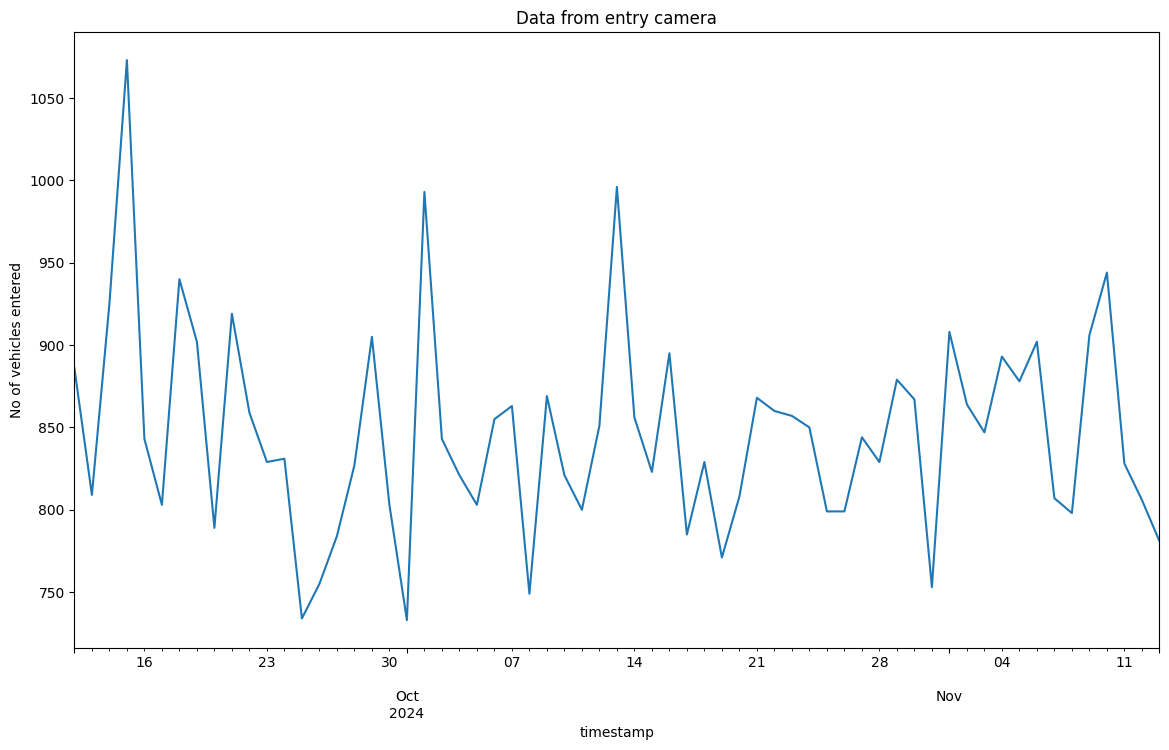

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#loading data
data = pd.read_csv("parkingLot (1).csv")

#converting timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

#spearating entry and exit data and resampling to consider only day
index = data['camera_id'] == 1

data_entry = data[index]
data_entry = data_entry.set_index('timestamp')
data_entry = data_entry.resample('D').size()

data_exit = data[~index]
data_exit = data_exit.set_index('timestamp')
data_exit = data_exit.resample('D').size()

#plottting entry data
fig, ax = plt.subplots()
ax.set_title('Data from entry camera')
ax.set_ylabel('No of vehicles entered')
data_entry.plot(ax= ax, figsize=(14, 8))

# Checking stationarity of data using ADF and Checking ACF and PACF

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


### plots for original data

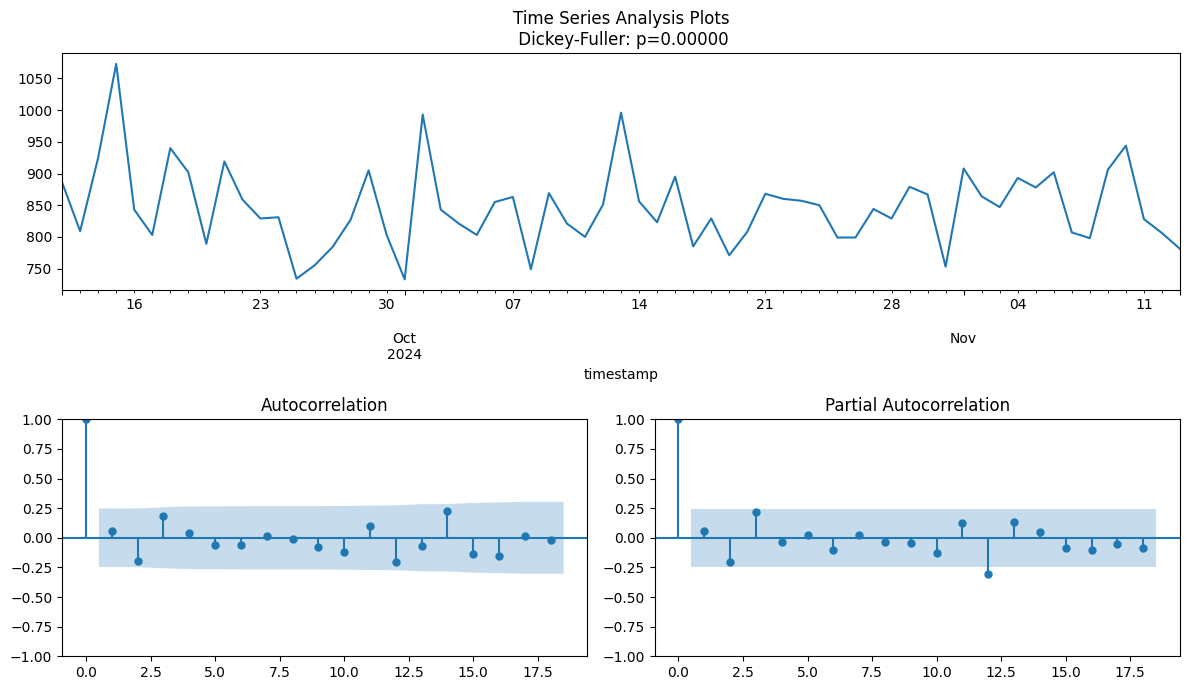

In [17]:
tsplot(data_entry)

### plots for first difference time series

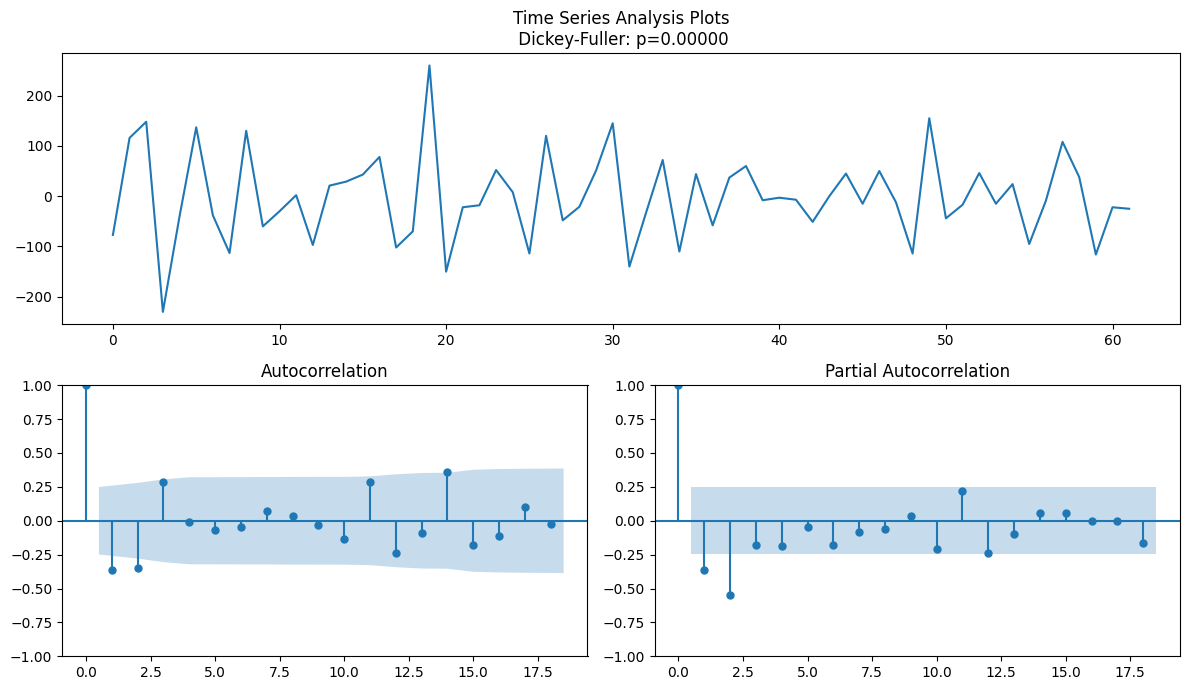

In [18]:
data_entry_diff_1 = (data_entry[i + 1] - data_entry[i] for i in range(len(data_entry) - 1))
tsplot(data_entry_diff_1)

#### Due to low p value of the original data we will countinue without differencing

# Test, Train Split

for (a) part of Q1 we only need to use data_entry

In [19]:
data_train = data_entry[:-7]
data_test = data_entry[-7:]

#  Fitting different model

1. Manual ARIMA Fitting
    - choosing p, d, q manually
2. Auto ARIMA Fittting
3. ETS

### Manual Fitting

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_train, order=(0,0,0), seasonal_order=(3, 0, 1, 7)).fit()
print(model.summary())

                                SARIMAX Results                                
Dep. Variable:                       y   No. Observations:                   56
Model:             ARIMA(3, 0, [1], 7)   Log Likelihood                -309.077
Date:                 Sun, 19 Jan 2025   AIC                            630.154
Time:                         22:52:49   BIC                            642.306
Sample:                     09-12-2024   HQIC                           634.865
                          - 11-06-2024                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        850.8044     12.316     69.083      0.000     826.666     874.943
ar.S.L7       -0.5285      4.476     -0.118      0.906      -9.301       8.244
ar.S.L14       0.3862      0.220      1.757 

### Auto Fitting

In [25]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train, stepwise=False, seasonal=True)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -307.874
Date:                Sun, 19 Jan 2025   AIC                            625.748
Time:                        22:52:19   BIC                            635.875
Sample:                    09-12-2024   HQIC                           629.674
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    848.3345     12.114     70.030      0.000     824.592     872.077
ma.L1          0.1820      0.153      1.190      0.234      -0.118       0.482
ma.L2         -0.2221      0.165     -1.347      0.178      -0.545       0.101
ma.L3          0.4028      0.146      2.751      0.006       0.116       0.690
sigma2      3422.8640    659.403      5.191      0.000    2130.458    4715.271
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 8.86
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.38   Skew:                             0.78
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ETS model

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Fitting an Exponential Smoothing model
model_ETS = ExponentialSmoothing(data_train, seasonal='add', trend='add', seasonal_periods=7).fit()

# Forecasting and Error Calculation


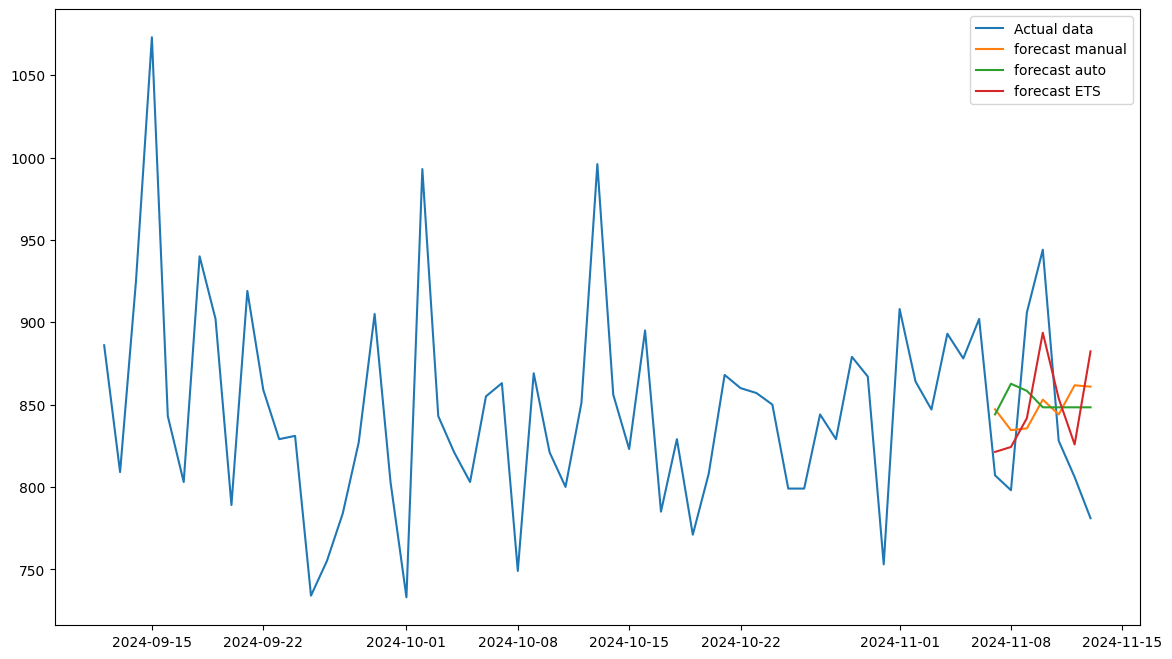

In [28]:
display_data = data_entry.copy()

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(data_entry, label = 'Actual data')

forecast_test = model.forecast(steps = len(data_test))
ax.plot(forecast_test, label='forecast manual')

forecast_test_auto = auto_arima.predict(n_periods=len(data_test))
ax.plot(forecast_test_auto, label='forecast auto')

forecast_test_ETS = model_ETS.forecast(steps=len(data_test))
ax.plot(forecast_test_ETS, label='forecast ETS')

plt.legend()
plt.show()

### Function for plotting individual models

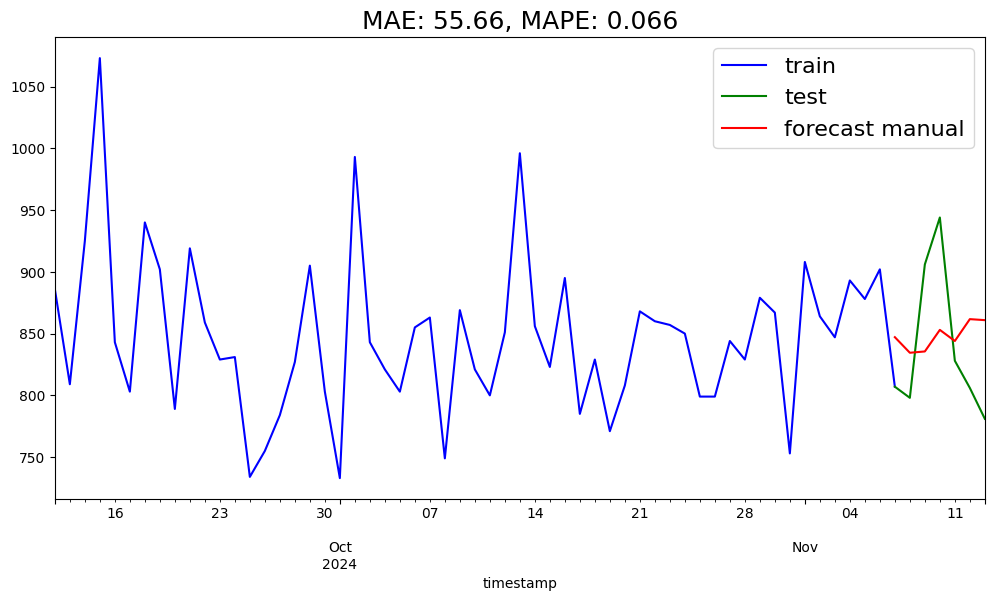

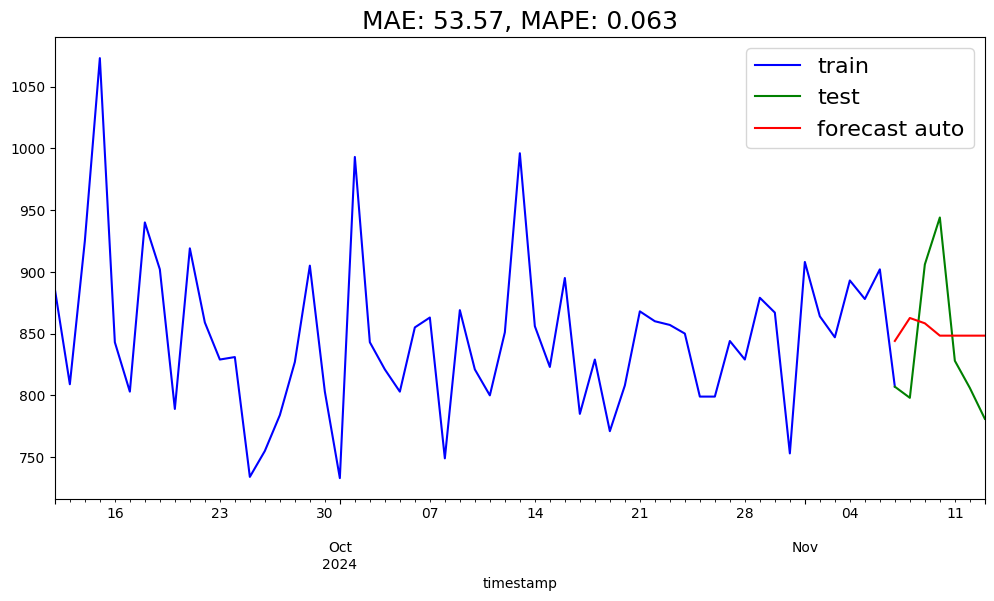

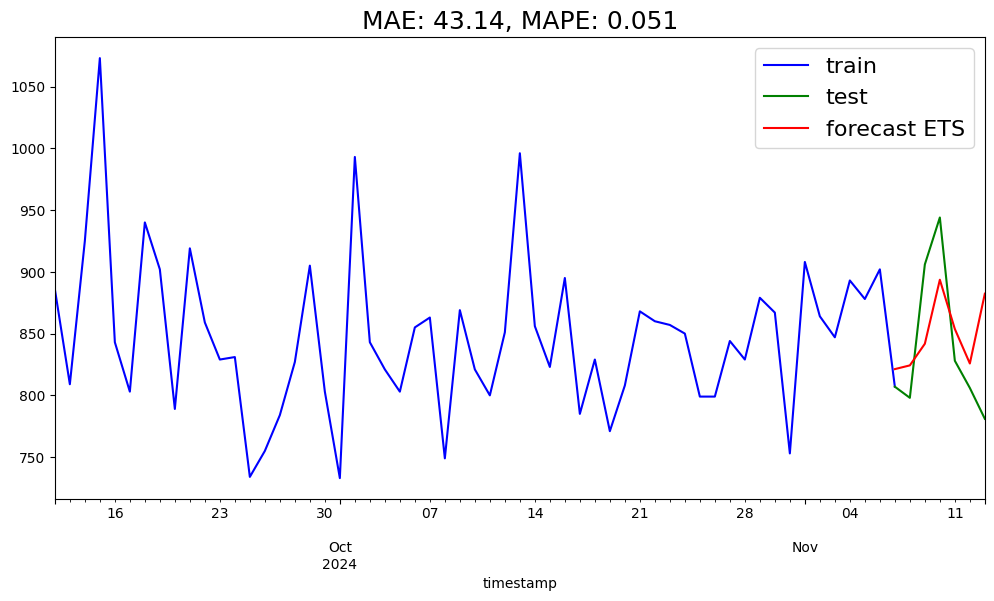

(43.13510959308682, 0.051452295343074404)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def plot_forecast(series_train, series_test, forecast, forecast_int=None, label="forecast"):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label=label, color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

plot_forecast(data_entry[0:-6], data_test, forecast_test, label='forecast manual')
plot_forecast(data_entry[0:-6], data_test, forecast_test_auto, label='forecast auto')
plot_forecast(data_entry[0:-6], data_test, forecast_test_ETS, label='forecast ETS')

### Error calculation for all 3 models

- MAE: Mean Absolute Error
- MAPE: Mam Absolute Percentage Error
- RMSE: Root Mean Squared Error

ETS model gives the least error

In [24]:
mae = mean_absolute_error(data_test, forecast_test)
mape = mean_absolute_percentage_error(data_test, forecast_test)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 55.66238734297732
mape - manual: 0.06575790745251114
rmse - manual: 60.85678105344298


In [26]:
mae = mean_absolute_error(data_test, forecast_test_auto)
mape = mean_absolute_percentage_error(data_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 53.573700141878966
mape - auto: 0.06345028898412906
rmse - auto: 58.203647817248786


In [27]:
mae = mean_absolute_error(data_test, forecast_test_ETS)
mape = mean_absolute_percentage_error(data_test, forecast_test_ETS)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_ETS))

print(f'mae - ETS: {mae}')
print(f'mape - ETS: {mape}')
print(f'rmse - ETS: {rmse}')

mae - ETS: 43.13510959308682
mape - ETS: 0.051452295343074404
rmse - ETS: 51.92476616513588
